In [ ]:
!pip install stable-baselines3
!pip install gymnasium
!pip install gym-anytrading
!pip install finta

In [ ]:
# OpenAI Gym
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, TradingEnv
from finta import TA

# RL
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO

# Processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data
import yfinance as yf


### Make datasets for each **agent**

In [ ]:
sp500 = yf.Ticker("^GSPC")

# action = False removes dividends and stock splits events
sp500_df1 = sp500.history(period="1y", interval="1d", actions=False)

sp500_df2 = sp500.history(start="2019-11-01", end="2022-11-01", interval="1d", actions=False)

sp500_df3 = sp500.history(start="2017-11-01", end="2019-11-01", interval="1d", actions=False)

sp500_df_all = sp500.history(start="2019-12-01", interval="1d", actions=False)
agents = [sp500_df1, sp500_df2, sp500_df3, sp500_df_all]

### Create Different Env for each agent

In [ ]:
def create_agents(agents):
  cusomtized_agent = []
  for sp500_df in agents:
    sp500_df['SMA'] = TA.SMA(sp500_df, 12)
    # Relative strength index
    sp500_df['RSI'] = TA.RSI(sp500_df)
    # On-balance volume
    sp500_df['OBV'] = TA.OBV(sp500_df)

    sp500_df.fillna(0, inplace=True)
    cusomtized_agent.append(sp500_df)

  return cusomtized_agent


datasets = create_agents(agents) #create multiple envs
env_1 = gym.make('stocks-v0',df = datasets[0], window_size=10, frame_bound=(60,180))
env_2 = gym.make('stocks-v0', df = datasets[1], window_size=10, frame_bound=(50,300))
env_3 = gym.make('stocks-v0', df = datasets[2], window_size=10, frame_bound=(50,150))
env_all = gym.make('stocks-v0', df = datasets[3], window_size=10, frame_bound=(50,150))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Build and Train agents

In [ ]:
#Build agents (only run it to train new models)

'''
env_make = lambda: env_1
env = DummyVecEnv([env_make])
model1 = PPO("MlpPolicy", env, verbose=1, learning_rate= 4e-1, gamma=0.98, batch_size=64, n_epochs=12, gae_lambda=0.98, clip_range_vf=0.2)
model1.learn(total_timesteps=1000000)
model1.save("model1b")

env_make = lambda: env_2
env = DummyVecEnv([env_make])#info: {'total_reward': 2225.51171875, 'total_profit': 1.1639945438193464,
model2 = PPO("MlpPolicy", env, verbose=1, learning_rate= 3e-5, gamma=0.97, batch_size=64, n_epochs=10, gae_lambda=0.97, clip_range_vf=0.2)
model2.learn(total_timesteps=1000000)
model2.save('model2b')

env_make = lambda: env_3
env = DummyVecEnv([env_make]) #{'total_reward': 279.200439453125, 'total_profit': 0.8999794639519141}
model3 = PPO("MlpPolicy", env, verbose=1, learning_rate= 3e-5, gamma=0.98, batch_size=64, n_epochs=12, gae_lambda=0.96, clip_range_vf=0.2)
model3.learn(total_timesteps=1000000)
model3.save('model3b')
'''

### Evaluation of All 3 agents

In [ ]:

#Model1 with env1
model1 = PPO.load('normal_model1a')
model2 = PPO.load('model2a')
model3 = PPO.load('model3a')
models = [model1, model2, model3]
def evaluation(models):
  model_num = ['model1', 'model2', 'model3']
  for m in range(len(models)):
    observation = env_all.reset(seed=2023)[0]
    portfolio_values = []
    actions_taken = []
    while True:
        observation = observation[np.newaxis, ...]
        action, _state = models[m].predict(observation)  # use the model to decide an action
        observation, reward, terminated, truncated, info = env_all.step(action)

        done = terminated or truncated

        if done:
            print("info:", info)
            break
        portfolio_values.append(info.get('total_profit'))  # Assuming 'total_value' is the portfolio value
        actions_taken.append(action)

    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    stability = np.std(daily_returns)


    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + daily_returns) - 1

    # Calculate annual return (assuming 252 trading days per year)
    annual_return = (1 + cumulative_returns[-1]) ** (252 / len(portfolio_values)) - 1
    # Calculate max drawdown
    peak_index = np.argmax(cumulative_returns)
    trough_index = np.argmin(cumulative_returns[peak_index:])
    max_drawdown = cumulative_returns[trough_index + peak_index]
    # Print and visualize the results
    print("Cumulative Returns:", "{:.2f}".format(cumulative_returns[-1]* 100), "%")
    print("Stability:","{:.2f}".format(stability * 100), "%")
    print("Max Drawdown:"+"{:.2f}".format(max_drawdown * 100), "%")

    plt.figure(figsize=(13,4))
    plt.cla()
    env_all.unwrapped.render_all()
    plt.title(model_num[m])
    plt.show()
    plt.plot(portfolio_values)
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.show()


info: {'total_reward': 647.000244140625, 'total_profit': 1.0310519490931989, 'position': <Positions.Long: 1>}
Cumulative Returns: 18.17 %
Stability: 2.11 %
Max Drawdown:13.17 %


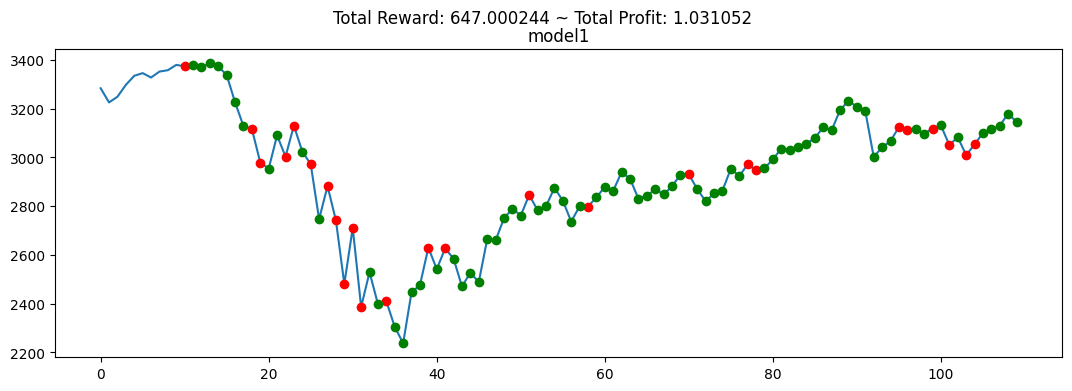

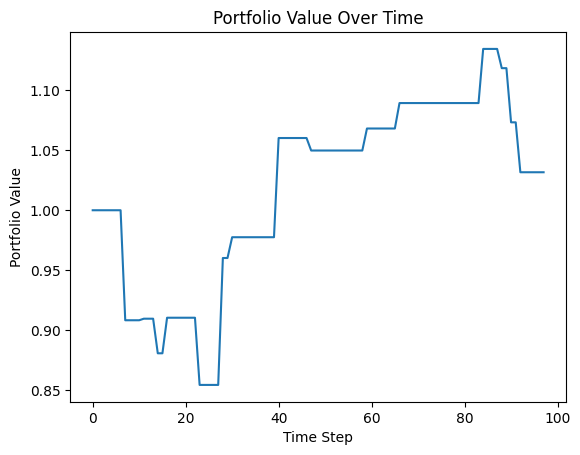

info: {'total_reward': 1079.570068359375, 'total_profit': 1.054889450459179, 'position': <Positions.Short: 0>}
Cumulative Returns: 21.09 %
Stability: 2.32 %
Max Drawdown:16.09 %


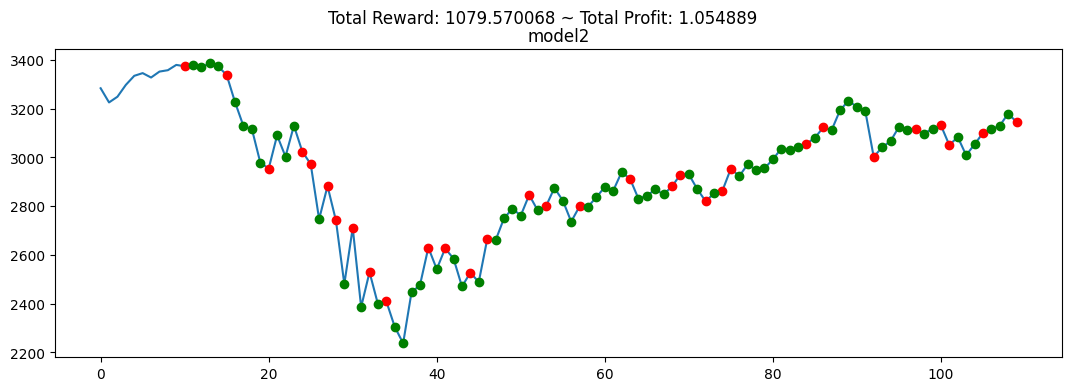

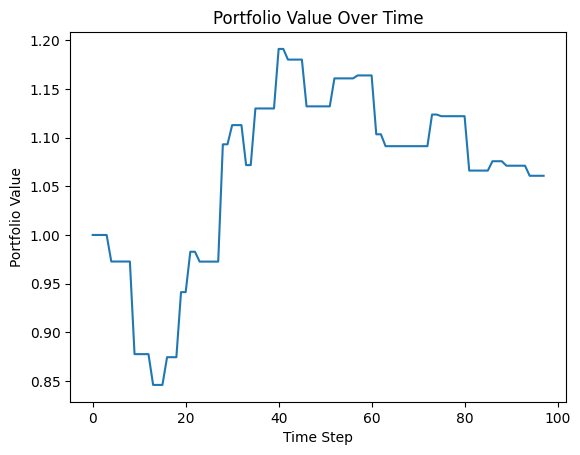

info: {'total_reward': -575.1298828125, 'total_profit': 0.7494955647630861, 'position': <Positions.Long: 1>}
Cumulative Returns: -11.14 %
Stability: 2.17 %
Max Drawdown:-16.14 %


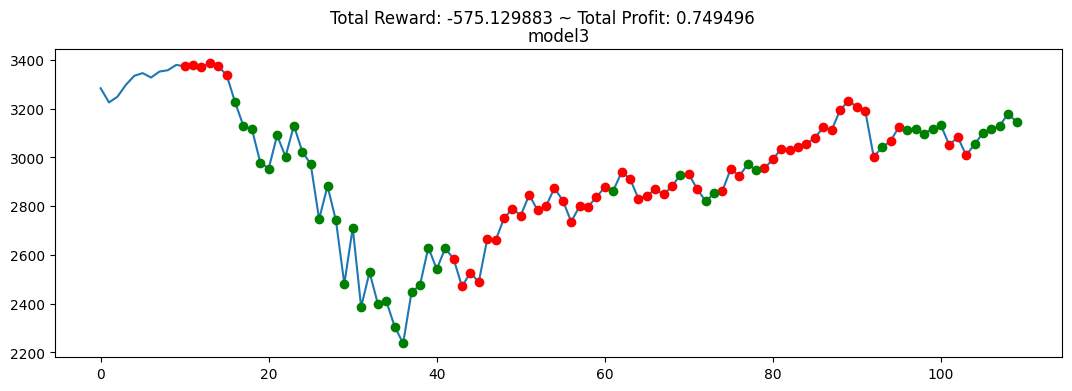

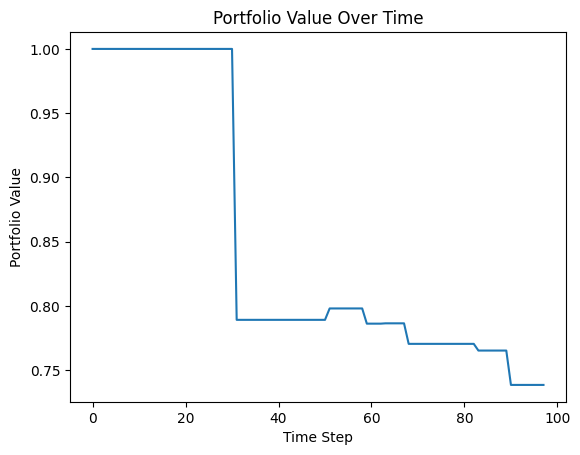

In [ ]:
evaluation(models) #Best run

### Temporal Ensemble Model

In [ ]:


class PPOEnsemble:
    def __init__(self, agents, env):
        self.agents = agents
        self.env = env


    def vote(self, choices):
      x=0
      y=0
      for choice in choices:
        if(choice==0):
          y+=1
        else:
          x+=1

      if(x>y):
        return 1
      return 0

    def go(self):
      portfolio_values = []
      actions_taken = []
      observation = self.env.reset(seed=2023)[0]
      while True:
          observation = observation[np.newaxis, ...]

          choices = []
          for model in self.agents:
              action, _states = model.predict(observation)
              choices.append(action)

          finalAction = self.vote(choices)
          observation, reward, terminated, truncated, info = self.env.step(finalAction)
          done = terminated or truncated

          if done:
              print("info:", info)
              break
          portfolio_values.append(info.get('total_profit'))  # Assuming 'total_value' is the portfolio value
          actions_taken.append(action)

      daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
      stability = np.std(daily_returns)


      # Calculate cumulative returns
      cumulative_returns = np.cumprod(1 + daily_returns) - 1

      # Calculate annual return (assuming 252 trading days per year)
      annual_return = (1 + cumulative_returns[-1]) ** (252 / len(portfolio_values)) - 1
      # Calculate max drawdown
      peak_index = np.argmax(cumulative_returns)
      trough_index = np.argmin(cumulative_returns[peak_index:])
      max_drawdown = cumulative_returns[trough_index + peak_index]
      # Print and visualize the results
      print("Cumulative Returns:", "{:.2f}".format(cumulative_returns[-1]* 100), "%")
      print("Annual Return:", "{:.2f}".format(annual_return * 100), "%")
      print("Stability:","{:.2f}".format(stability * 100), "%")
      print("Max Drawdown:"+"{:.2f}".format(max_drawdown * 100), "%")

      plt.figure(figsize=(13,4))
      plt.cla()
      env_all.unwrapped.render_all()
      plt.title("ensemble_model")
      plt.show()
      plt.plot(portfolio_values)
      plt.xlabel('Time Step')
      plt.ylabel('Portfolio Value')
      plt.title('Portfolio Value Over Time')
      plt.show()


### Temporal Ensemble Model Evaluation

info: {'total_reward': 1206.00048828125, 'total_profit': 1.108332165159988, 'position': <Positions.Short: 0>}
Cumulative Returns: 10.83 %
Annual Return: 30.28 %
Stability: 1.35 %
Max Drawdown:10.25 %


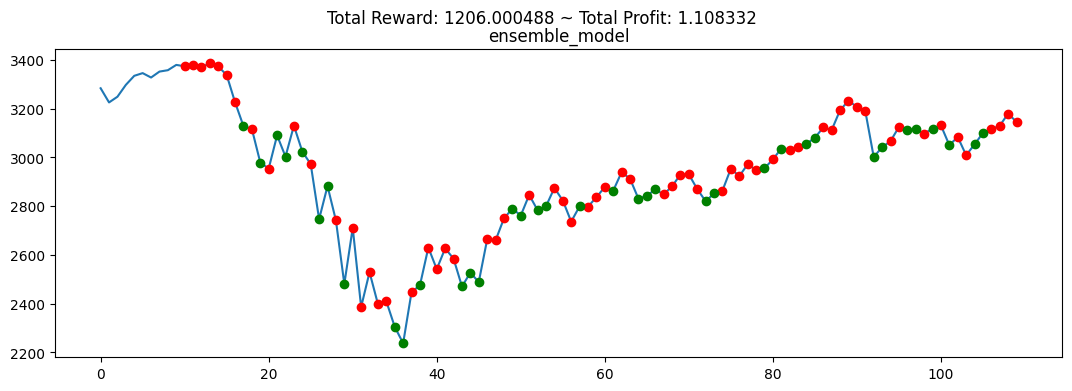

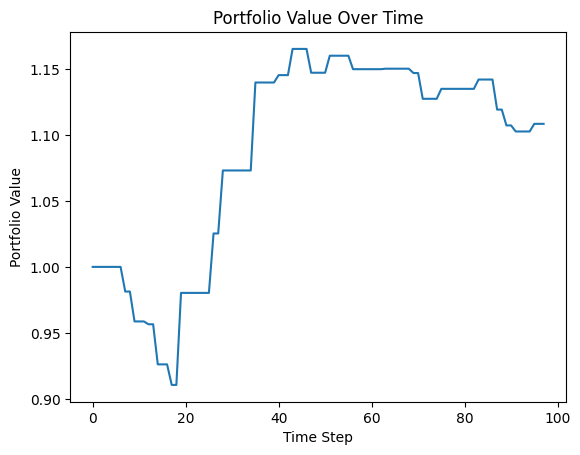

In [ ]:
ensemble = PPOEnsemble(model1,model2,model3,model2,env_all)
ensemble.go()

##Notes for tuning the parameters
LEARNING RATE
lower learning rate on most relevant data
1 year: 1e-4
3 year: 5e-3
5 year: 1e-3


GAMMA
Between  0.9 and 0.99 lower gamma priortize short term reward

BATCH SIZE
64 due to limited memory and computational resource

n_epochs=10

GAE LAMBDA
gae_lambda 0.95 to 0.99. higher for more recent year data as they are more indicative.


policy_clip =0.2


## References

yfinance: https://algotrading101.com/learn/yfinance-guide/

PPO Agent: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

anytrading: https://github.com/AminHP/gym-anytrading

normal env: https://youtu.be/D9sU1hLT0QY?si=AxD6GydO3FlavCu6

custom env: https://youtu.be/q-Uw9gC3D4o?si=XG8RrH_GbmsNW-ao